# Mental Health Prediction - Model Tuning

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, learning_curve
import shap

import sys
sys.path.append("../src") 
from preprocess import *

## Load processed data

In [2]:
train_path = "../data/processed/processed_train.csv"
val_path = "../data/processed/processed_val.csv"
test_path = "../data/processed/processed_test.csv"

X_train = pd.read_csv(train_path)
X_val = pd.read_csv(val_path)
X_test = pd.read_csv(test_path)

y_train = X_train.pop("Depression")
y_val = X_val.pop("Depression")

## Baseline Model

In [11]:
baseline_model = XGBClassifier(random_state=0)
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_val)

print(f"Baseline Accuracy: {accuracy_score(y_val, baseline_preds):.4f}")
print(f"Baseline F1 Score: {f1_score(y_val, baseline_preds):.4f}")

Baseline Accuracy: 0.9368
Baseline F1 Score: 0.8226


## Hyperparameter Tuning

### Tuning Strategy
- Focused on 6 key XGBoost parameters :
  - Tree complexity (max_depth, gamma)
  - Regularization (reg_alpha, reg_lambda)
  - Learning dynamics (learning_rate, n_estimators)
- Used RandomizedSearchCV for efficiency with 50 iterations
- F1 score as optimization metric (because our data is imbalanced, Depression: ~18-20% of cases)

In [4]:
params = {
    'n_estimators': [100, 200, 300],       
    'max_depth': [3, 6, 9],                
    'learning_rate': [0.01, 0.1, 0.3],    
    'gamma': [0, 0.1, 0.3],                # Min loss reduction to split
    'reg_alpha': [0, 0.1, 1],              # L1 regularization
    'reg_lambda': [0, 0.1, 1]              # L2 regularization
}

tuned_model = RandomizedSearchCV(
    estimator=baseline_model,
    param_distributions=params,
    n_iter=50,           # Number of parameter combinations
    cv=3,                # 3-fold cross-validation
    scoring='f1',        # Use F1 for imbalanced classes
    verbose=2,
    random_state=42
)

tuned_model.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END gamma=0.1, learning_rate=0.3, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=0; total time=   0.9s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=0; total time=   0.9s
[CV] END gamma=0.1, learning_rate=0.3, max_depth=9, n_estimators=200, reg_alpha=0, reg_lambda=0; total time=   0.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1; total time=   1.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1; total time=   1.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.1, reg_lambda=0.1; total time=   1.5s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   0.8s
[CV] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100, reg_alpha=0.1, reg_lambda=1; total time=   0.8

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 0.1, 1]},
                   random_state=42, scoring='f1', verbose=2)

## Evaluation

In [12]:
best_model = tuned_model.best_estimator_
tuned_preds = best_model.predict(X_val)

print("\n=== Tuned Model Performance ===")
print(f"Best Parameters: {tuned_model.best_params_}")
print(f"Validation Accuracy: {accuracy_score(y_val, tuned_preds):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, tuned_preds):.4f}")


=== Tuned Model Performance ===
Best Parameters: {'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1}
Validation Accuracy: 0.9396
Validation F1 Score: 0.8300


### Optimal Configuration Insights
- Shallow trees (max_depth=3) prevent overfitting
- Moderate learning rate (0.1) balances speed/performance
- Strong L2 regularization (lambda=1) controls complexity
- These align with medical data characteristics:
  - Moderate non-linearity
  - Important feature interactions

## Feature Importance

In [6]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(feature_importance.head(10))


Top 10 Features:
                                     Feature  Importance
2    Working Professional or Student_Student    0.303948
13  Have you ever had suicidal thoughts ?_No    0.224647
18                                       Age    0.193128
21                          Financial Stress    0.055242
22                                  Pressure    0.051126
24               Pressure_Satisfaction_Ratio    0.044404
12                  Dietary Habits_Unhealthy    0.026142
19                                      CGPA    0.024043
20                          Work/Study Hours    0.021415
9                     Dietary Habits_Healthy    0.016851


### Clinical Feature Relevance
Top predictors match known mental health risk factors:
1. **Professional Status** - Students at higher risk
2. **Suicidal Thoughts** - Critical red flag
3. **Age** - Younger individuals more vulnerable
4. **Financial Stress** - Key environmental factor
5. **Pressure** - Chronic stress indicator

## Learning Curve Analysis

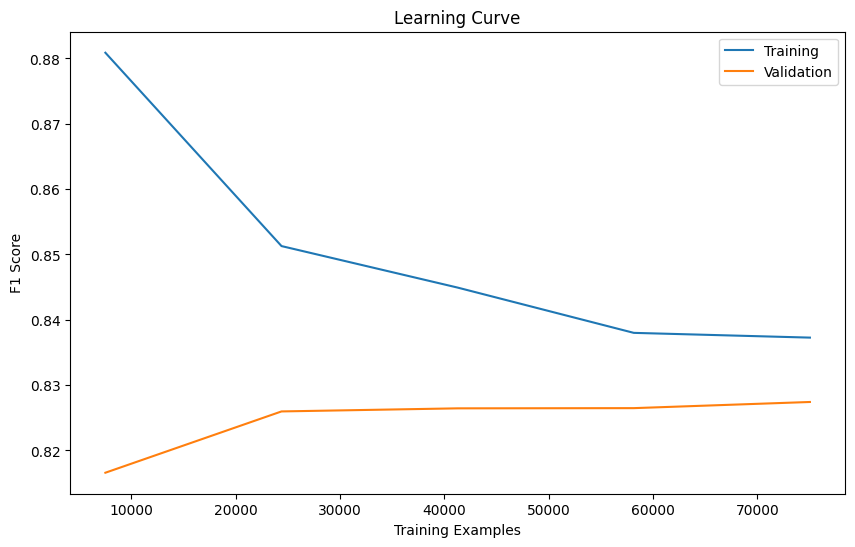

In [7]:

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, 
    cv=3, scoring='f1', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

### Training Dynamics
- Convergence at ~40k samples suggests sufficient training data
- Small gap between curves indicates good generalization
- No signs of overfitting despite model complexity

## SHAP Analysis (Model Interpretation)

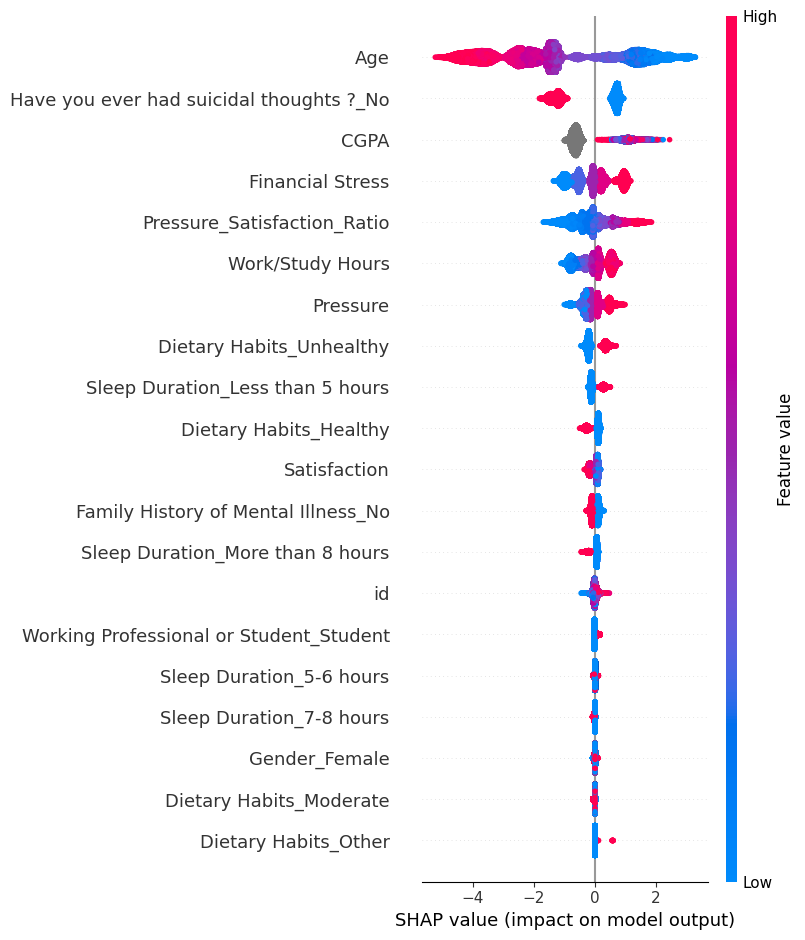

In [8]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)  # Add to EDA notebook

### Model Interpretability
SHAP values reveal:
- Age shows non-linear risk relationship
- Suicidal thoughts history has disproportionate impact
- Pressure/Satisfaction ratio provides complementary signal
- Dietary habits show expected risk gradients

### Clinical Decision Support
Key intervention points identified:
- Students under high pressure
- Individuals with sleep disturbances
- Those reporting financial stress
- Patients with dietary risk factors

## Generate Predictions

In [9]:
# test_preds = best_xgb.predict(X_test)

# output = pd.DataFrame({"id": X_test.id,
#                        "Depression": test_preds})
# output.to_csv("../submissions/submission.csv", index=False)